In [72]:
class Config:
    def __init__(self):
        pass

def set_config(config_dict):
    config = Config()
    config.__dict__ = config_dict
    return config

# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import adam_v2
from keras import backend as K

%matplotlib inline

columns_train = ['tavg', 'rh_avg', 'rr', 'ff_avg']
# columns_train = ['Open', 'High', 'Low', 'Close', 'Adj Close']

config = set_config({
    "input_size": columns_train.__len__(),
    "seq_len": 90,
    "batch_size": 256,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": True,
    "learning_rate": 0.01,
    "max_epochs": 30,
    "time_col": 'tanggal',
    # "time_col": 'Date',
    "prediction_col": columns_train[0],
    'much_day_predict': 60,
    'validation_split': 0.1,
})

usecols = [config.time_col] + columns_train

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [73]:
dataset_train = pd.read_csv('../Assets/Data/1985-2021.csv', usecols=usecols).replace(to_replace=[8888, 9999, 2555], value=np.nan)
# dataset_train = pd.read_csv('../Assets/Data/GOOG.csv')

datelist_train = list(dataset_train[config.time_col])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(columns_train))

Training set shape == (13028, 5)
All timestamps == 13028
Featured selected: ['tavg', 'rh_avg', 'rr', 'ff_avg']


In [74]:
dataset_train = dataset_train[columns_train]
dataset_train.interpolate(inplace=True)

# dataset_train = dataset_train[columns_train].astype(str)
# for i in columns_train:
#     for j in range(0, len(dataset_train)):
#         dataset_train[i][j] = dataset_train[i][j].replace(',', '')

# dataset_train = dataset_train.astype(float)

training_set = dataset_train.values
print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (13028, 4).


In [75]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.5625  ],
       [0.796875],
       [0.875   ],
       ...,
       [0.75    ],
       [0.828125],
       [0.90625 ]])

In [76]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = config.much_day_predict   # Number of days we want top predict into the future
n_past = config.seq_len     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (12879, 90, 3).
y_train shape == (12879, 1).


In [77]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import adam_v2

In [78]:
model = Sequential()

model.add(LSTM(units=config.hidden_size, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(config.dropout))
model.add(Dense(units=config.output_size, activation='linear'))

model.compile(optimizer = adam_v2.Adam(learning_rate=config.learning_rate), loss=root_mean_squared_error)
# model.compile(optimizer = adam_v2.Adam(learning_rate=config.learning_rate), loss='mean_squared_error')

In [79]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=config.max_epochs, callbacks=[es, rlr, mcp, tb], validation_split=config.validation_split, verbose=1, batch_size=config.batch_size)

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.1213
Epoch 00001: val_loss improved from inf to 0.09889, saving model to weights.h5
46/46 [==============================] - 28s 400ms/step - loss: 0.1213 - val_loss: 0.0989 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.0978
Epoch 00002: val_loss did not improve from 0.09889
46/46 [==============================] - 16s 347ms/step - loss: 0.0978 - val_loss: 0.1092 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.0950
Epoch 00003: val_loss improved from 0.09889 to 0.09355, saving model to weights.h5
46/46 [==============================] - 15s 335ms/step - loss: 0.0950 - val_loss: 0.0935 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - ETA: 0s - loss: 0.0919
Epoch 00004: val_loss did not improve from 0.09355
46/46 [==============================] - 16s 341ms/step - loss: 0.0919 - val_loss: 0.0943 - lr: 0.0100
Epoch 5/30
46/46 [======

In [80]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [81]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [82]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=[config.prediction_col]).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[config.prediction_col]).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,rh_avg
1985-08-28,69.716049
1985-08-29,69.497673
1985-08-30,69.297340


In [83]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=columns_train)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

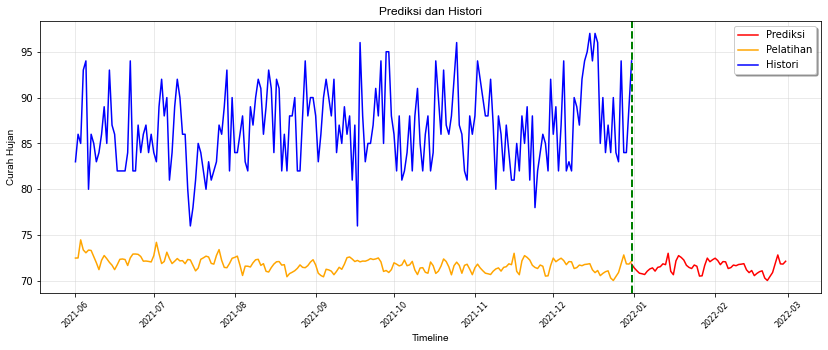

In [84]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[config.prediction_col], color='r', label='Prediksi')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][config.prediction_col], color='orange', label='Pelatihan')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:][config.prediction_col], color='b', label='Histori')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Prediksi dan Histori', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Curah Hujan', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()